In [72]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
from tensorflow import keras
from pathlib import Path
import matplotlib.pyplot as plt

movielens_data_file_url = (
    "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"

df = pd.read_csv(ratings_file, header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Need to map movie ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1
for index, row in df.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        df.at[index, 'movie_id'] = id
        id += 1
    else:
        df.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

num_users = len(df.user_id.unique())
num_movies = len(df.movie_id.unique())
train, validate, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

978202/978202 [==============================] - 0s 0us/step


In [73]:
print(len(train))
print(len(validate))
print(len(test))

80668
10084
10084


In [74]:
num_movies

9724

In [75]:
num_users

610

In [76]:
df

,user_id,movie_id,rating,timestamp
0,1,1,4.0,964982703
1,1,2,4.0,964981247
2,1,3,4.0,964982224
3,1,4,5.0,964983815
4,1,5,5.0,964982931
...,...,...,...,...
100831,610,3121,4.0,1493848402
100832,610,2036,5.0,1493850091
100833,610,3122,5.0,1494273047
100834,610,1393,5.0,1493846352


In [77]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dot, Dropout, Dense
from keras.optimizers import Adam

latent_dim = 10

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

concat = Dot(axes=1, name='movie-user-concat')([movie_vec, user_vec])
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(128, name='fc-1', activation='relu',  kernel_regularizer="l2")(concat)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(64, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)


model = Model([user_input, movie_input], fc_3)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [78]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding (Embedding)    (None, 1, 10)        97250       ['movie-input[0][0]']            
                                                                                                  
 user-embedding (Embedding)     (None, 1, 10)        6110        ['user-input[0][0]']             
                                                                                           

In [79]:
from sklearn.metrics import mean_absolute_error
history = model.fit(
    x=[train.user_id, train.movie_id], 
    y=train.rating, 
    epochs=50, 
    batch_size=128,
    shuffle=True, 
    validation_data=([validate.user_id, validate.movie_id], validate.rating)
)

Epoch 1/50
631/631 [==============================] - 1s 932us/step - loss: 1.9641 - val_loss: 1.0764
Epoch 2/50
631/631 [==============================] - 0s 791us/step - loss: 1.1696 - val_loss: 0.9473
Epoch 3/50
631/631 [==============================] - 0s 786us/step - loss: 0.8597 - val_loss: 0.8743
Epoch 4/50
631/631 [==============================] - 0s 784us/step - loss: 0.6718 - val_loss: 0.8639
Epoch 5/50
631/631 [==============================] - 1s 795us/step - loss: 0.5856 - val_loss: 0.8628
Epoch 6/50
631/631 [==============================] - 1s 823us/step - loss: 0.5351 - val_loss: 0.8821
Epoch 7/50
631/631 [==============================] - 1s 792us/step - loss: 0.5043 - val_loss: 0.8855
Epoch 8/50
631/631 [==============================] - 1s 793us/step - loss: 0.4803 - val_loss: 0.9106
Epoch 9/50
631/631 [==============================] - 1s 833us/step - loss: 0.4613 - val_loss: 0.9199
Epoch 10/50
631/631 [==============================] - 0s 791us/step - loss: 0.439

<AxesSubplot: >

<AxesSubplot: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Error')

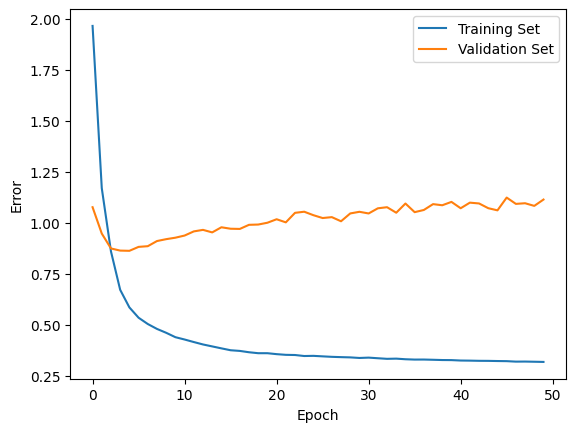

316/316 [==============================] - 0s 323us/step


0.8056832621349129

In [142]:
pd.Series(history.history['loss']).plot(label="Training Set")
pd.Series(history.history['val_loss']).plot(label="Validation Set")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

In [149]:
import evaluation
"mae", evaluation.mean_absolute_error(y_true, y_hat)
"rmse", evaluation.root_mean_squared_error(y_true, y_hat)

('mae', 0.8056832621349129)

('rmse', 1.0718302784903309)

In [291]:
movies = pd.read_csv("./data/movies.csv")

def getUserTopMovies(user_id: int) -> pd.DataFrame:
    movie_ids = test.movie_id.unique()
    predictions = model.predict([np.array([user_id] * len(movie_ids)), movie_ids])
    combined = pd.DataFrame({'movie_id': movie_ids, 'predicted_rating': [_[0] for _ in predictions]})
    #sort ratings descending
    combined = combined.sort_values(by="predicted_rating", ascending=False)
    #append movie titles to DataFrame
    combined = combined.set_index('movie_id').join(movies.set_index('movieId')).drop(columns = ["genres"])
    #drop null entries
    combined = combined.dropna()
    #make movie_id a column
    return combined.reset_index(level=0)


In [306]:
topMovies = getUserTopMovies(111)
topMovies.loc[topMovies.movie_id == 1956]
test.loc[(test.movie_id == 1956) & (test.user_id == 111)]

116/116 [==============================] - 0s 318us/step


,movie_id,predicted_rating,title
268,1956,4.146917,Ordinary People (1980)


,user_id,movie_id,rating,timestamp
17731,111,1956,4.5,1516152160


In [307]:
topMovies = getUserTopMovies(564)
topMovies.loc[topMovies.movie_id == 1956]
validate.loc[(validate.movie_id == 1956) & (validate.user_id == 564)]

116/116 [==============================] - 0s 576us/step


,movie_id,predicted_rating,title
1742,1956,3.018424,Ordinary People (1980)


,user_id,movie_id,rating,timestamp
87646,564,1956,4.0,1478451528


In [308]:
topMovies = getUserTopMovies(21)
topMovies.loc[topMovies.movie_id == 1956]
train.loc[(train.movie_id == 1956) & (train.user_id == 21)]

116/116 [==============================] - 0s 311us/step


,movie_id,predicted_rating,title
462,1956,3.835445,Ordinary People (1980)


,user_id,movie_id,rating,timestamp
3546,21,1956,4.0,1376823593
